# **House Prices: Advanced Regression Techniques**

# 1.0 Exploratory analysis of data

## 1.1 Read the datasets

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from scipy.special import inv_boxcox
from sklearn.compose import TransformedTargetRegressor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1.2 Get the number of rows and columns (shape)

In [8]:
print(df_train.shape)
print(df_test.shape)
print(set(df_train.columns.values) - set(df_test.columns.values))

(1460, 81)
(1459, 80)
{'SalePrice'}


Results:
* The train dataset has 1.460 rows and 81 columns
* The test dataset has 1.459 rows and 80 columns
* The train dataset has then target variable "Sale

## 1.3 Get the column types

In [9]:
df_train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

Results:
* The dataset has 3 types of columns: strings, integers and floats

## 1.4 Check distinct value counts for categorical features

In [10]:
col_types = df_train.dtypes
unique_count = df_train.nunique()
unique_count[col_types[col_types == 'object'].index].sort_values(ascending = False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
SaleCondition     6
BsmtFinType2      6
Heating           6
Foundation        6
GarageType        6
RoofStyle         6
BsmtFinType1      6
ExterCond         5
BldgType          5
LotConfig         5
MSZoning          5
GarageCond        5
GarageQual        5
HeatingQC         5
Electrical        5
FireplaceQu       5
LotShape          4
LandContour       4
MiscFeature       4
Fence             4
BsmtExposure      4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
GarageFinish      3
PavedDrive        3
PoolQC            3
LandSlope         3
Utilities         2
CentralAir        2
Alley             2
Street            2
dtype: int64

In [11]:
df_train.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [12]:
df_train.Exterior2nd.value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [13]:
df_train.Exterior1st.value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
CBlock       1
ImStucc      1
AsphShn      1
Name: Exterior1st, dtype: int64

Results:
* Neighborhood, Exterior2nd, Exterior1st are the features with higher distinct values
* Some values are in few samples

## 1.5 Check columns with NANs

This check should be done in both train and test dataset

In [14]:
df_total = pd.concat([df_train.drop('SalePrice', axis=1), df_test],axis=0)
null_cols = df_total.isnull().sum()
print(len(null_cols[null_cols > 0]))
null_cols[null_cols > 0].sort_values(ascending = False)

34


PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

Results:
* There are 19 columns with NAs
* Alley, FireplaceQu, PoolQC, Fence, MiscFeature have too many NA

In [15]:
df_total.PoolQC.unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

NaN values of PoolQC means that there is no pool in the property

In [16]:
df_total.MiscFeature.unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

NaN values of MiscFeature means that there is no special feature in the property

In [17]:
df_total.Alley.unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

NaN values of MiscFeature means that there is no alley in the property

In [18]:
df_total.Fence.unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

NaN values of Fence means that there is no fence in the property

In [19]:
df_total.FireplaceQu.unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

NaN values of FireplaceQu means that there is no fence in the property

In [20]:
df_total.LotFrontage.unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.,  26.,  25., 119.,  31.,  28., 117., 113., 125., 135., 136.,
        22., 123., 195., 155., 126., 200., 131., 133.])

NaN values of LotFrontage could be a "real" missing value or that the property is not directly connected to the street

In [21]:
df_total.GarageType.unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

NaN values of GarageType means that there is no garage in the property

The other columns related to garage (GarageYrBlt, GarageFinish, GarageQual, GarageCond, GarageCars) are NaN or 0 when GarageType is missing

In [22]:
print(df_total[df_total.GarageType.isnull()]['GarageYrBlt'].unique())
print(df_total[df_total.GarageType.isnull()]['GarageFinish'].unique())
print(df_total[df_total.GarageType.isnull()]['GarageQual'].unique())
print(df_total[df_total.GarageType.isnull()]['GarageCond'].unique())
print(df_total[df_total.GarageType.isnull()]['GarageCars'].unique())

[nan]
[nan]
[nan]
[nan]
[0.]


In [23]:
df_total[['GarageType','GarageQual','GarageCond', 'GarageYrBlt','GarageCars']][(df_total.GarageType.isnull() == False) 
    & (df_total.GarageQual.isnull() | df_total.GarageCond.isnull() |
      df_total.GarageYrBlt.isnull() | df_total.GarageCars.isnull())]

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageCars
666,Detchd,NaN,NaN,NaN,1.0
1116,Detchd,NaN,NaN,NaN,NaN


In [24]:
df_total.BsmtFinType1.unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

NaN values of BsmtFinType1 means that there is no basemente in the property. Let's see all basement related features.

In [25]:
df_total[['BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond','BsmtQual']][df_total.BsmtFinType1.isnull() | df_total.BsmtExposure.isnull()]

,BsmtFinType2,BsmtExposure,BsmtFinType1,BsmtCond,BsmtQual
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN,NaN


In [26]:
df_total.MasVnrType.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [27]:
df_total['MasVnrArea'][df_total.MasVnrType.isnull()]

234       NaN
529       NaN
650       NaN
936       NaN
973       NaN
977       NaN
1243      NaN
1278      NaN
231       NaN
246       NaN
422       NaN
532       NaN
544       NaN
581       NaN
851       NaN
865       NaN
880       NaN
889       NaN
908       NaN
1132      NaN
1150    198.0
1197      NaN
1226      NaN
1402      NaN
Name: MasVnrArea, dtype: float64

In [28]:
df_total['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [29]:
df_total['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH', nan], dtype=object)

In [30]:
df_total['Functional'].unique()

array(['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev', nan],
      dtype=object)

In [31]:
df_total['BsmtHalfBath'].unique()

array([ 0.,  1.,  2., nan])

In [32]:
df_total['BsmtFullBath'].unique()

array([ 1.,  0.,  2.,  3., nan])

In [33]:
df_total['Utilities'].unique()

array(['AllPub', 'NoSeWa', nan], dtype=object)

In [34]:
df_total['SaleType'].unique()

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth',
       nan], dtype=object)

Results:
* PoolQC, MiscFeature, Alley, Fence, FireplaceQu could not exist in the property and there is a predefined values for NaNs 
* NaN values of LotFrontage could be a "real" missing value or that the property is not directly connected to the street
* When BsmtFinType1 is NaN, the property has no basement, so the other 4 features are also NaN
* BsmtFinType2 and BsmtExposure could be NaN even if there is a basement
* When GarageType is missing, GarageYrBlt, GarageFinish, GarageQual, GarageCond, GarageCars are NaN too
* There are few samples where GarageType is not missing, but the other features ara NaN
* When MasVnrType is NaN, MasVnrArea is 0
* Electrical could be NaN, but there must be an electrical system in the property
* MSZoning doesn't have a predefined value for NaNs
* Functional could be NaN and has a typical value 
* NaN values for BsmtHalfBath and BsmtFullBath could mean that there is no bathroom in the basement
* Utilities, SaleType, KitchenQual, BsmtUnfSF, BsmtFinSF1, BsmtFinSF2, Exterior1st, Exterior2nd NaNs need to be treated (ex. mode)

## 1.6 Check for outliers

In [35]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [36]:
desc_train = df_train.describe().T
desc_train[desc_train['max'] > desc_train['mean'] + desc_train['std'] * 3].index

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice'],
      dtype='object')

In [37]:
desc_train = df_train.describe().T
desc_train[desc_train['min'] < desc_train['mean'] - desc_train['std'] * 3].index

Index(['OverallQual', 'OverallCond', 'YearBuilt', 'BedroomAbvGr',
       'KitchenAbvGr', 'GarageYrBlt'],
      dtype='object')

Results:
* Looking at the columns meanings and min-max values, probably these are not outliers. 

## 1.7 Look for columns that have too many unique values

In [38]:
unique_count = df_train.nunique()
unique_count[unique_count > len(df_train)*0.75]

Id    1460
dtype: int64

Results:
* Id column must be removed

## 1.8 Check the correlation between features

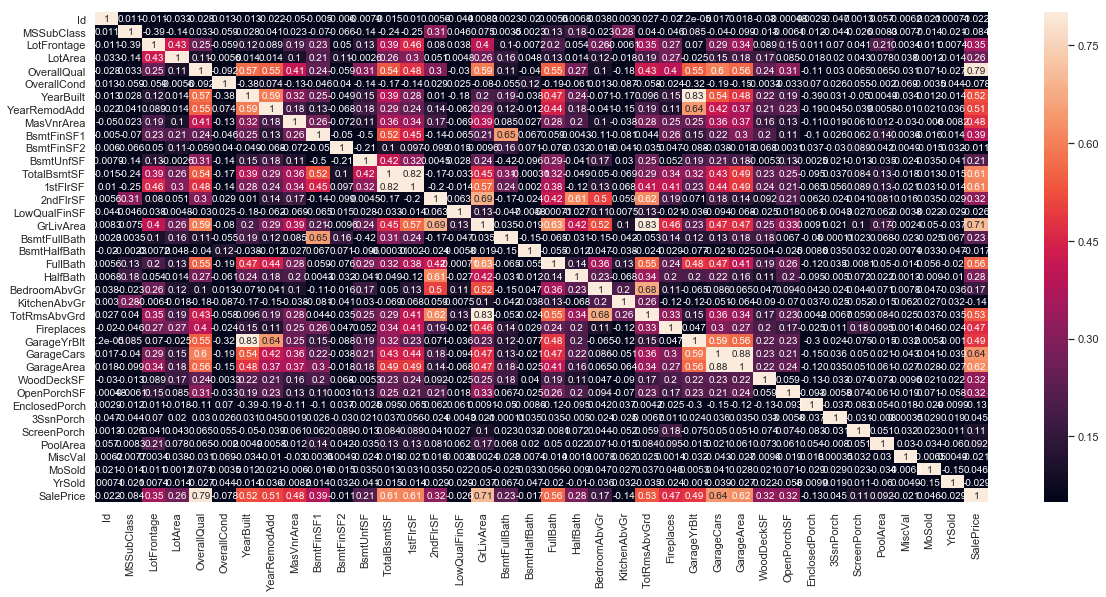

In [39]:
corr_matrix = df_train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr_matrix, vmax=0.8, vmin=0.05, annot=True);

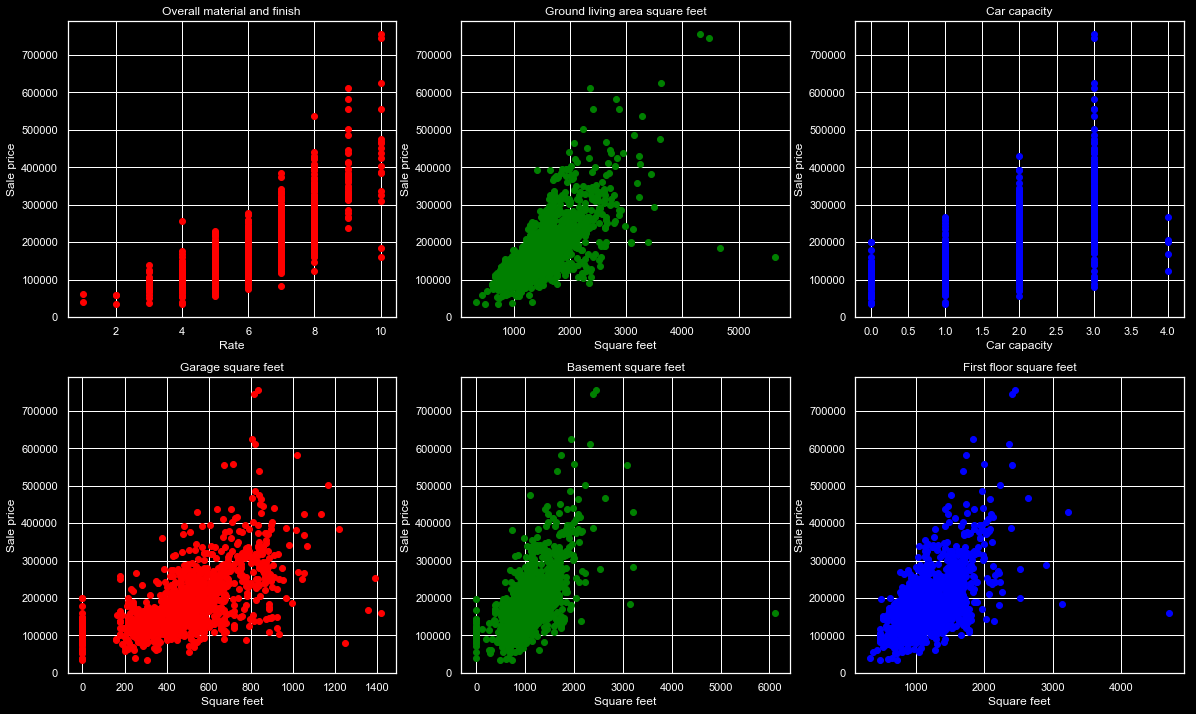

In [40]:
plt.style.use('dark_background')
fig, axes = plt.subplots(nrows= 2,ncols = 3, figsize=(20,12))

axes[0,0].scatter(df_train['OverallQual'], df_train['SalePrice'], marker = 'o', color='red')
axes[0,1].scatter(df_train['GrLivArea'], df_train['SalePrice'], marker = 'o', color='green')
axes[0,2].scatter(df_train['GarageCars'], df_train['SalePrice'], marker = 'o', color='blue')
axes[1,0].scatter(df_train['GarageArea'], df_train['SalePrice'], marker = 'o', color='red')
axes[1,1].scatter(df_train['TotalBsmtSF'], df_train['SalePrice'], marker = 'o', color='green')
axes[1,2].scatter(df_train['1stFlrSF'], df_train['SalePrice'], marker = 'o', color='blue')

axes[0,0].set_title('Overall material and finish')
axes[0,1].set_title('Ground living area square feet')
axes[0,2].set_title('Car capacity')
axes[1,0].set_title('Garage square feet')
axes[1,1].set_title('Basement square feet')
axes[1,2].set_title('First floor square feet')

axes[0,0].set_xlabel('Rate')
axes[0,0].set_ylabel('Sale price');
axes[0,1].set_xlabel('Square feet')
axes[0,1].set_ylabel('Sale price');
axes[0,2].set_xlabel('Car capacity')
axes[0,2].set_ylabel('Sale price');
axes[1,0].set_xlabel('Square feet')
axes[1,0].set_ylabel('Sale price');
axes[1,1].set_xlabel('Square feet')
axes[1,1].set_ylabel('Sale price');
axes[1,2].set_xlabel('Square feet')
axes[1,2].set_ylabel('Sale price');

Results:
* The columns that are more correlated with the target are: OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF
* For Linear Regression, I should keep one of these columns correlated columns:
  * YearBuilt or GarageYrBlt
  * GrLivArea or TotRmsAbvGrd
  * GarageCars or GarageArea
  * TotalBsmtSF or 1stFlrSF

# 1.9 Check the distributions of continuous numeric features

(array([ 11.,  38.,  99., 232., 273., 218., 176., 104.,  93.,  58.,  42.,
         35.,  24.,  10.,  17.,   8.,   7.,   4.,   2.,   1.,   1.,   2.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   2.]),
 array([ 34900.        ,  58903.33333333,  82906.66666667, 106910.        ,
        130913.33333333, 154916.66666667, 178920.        , 202923.33333333,
        226926.66666667, 250930.        , 274933.33333333, 298936.66666667,
        322940.        , 346943.33333333, 370946.66666667, 394950.        ,
        418953.33333333, 442956.66666667, 466960.        , 490963.33333333,
        514966.66666667, 538970.        , 562973.33333333, 586976.66666667,
        610980.        , 634983.33333333, 658986.66666667, 682990.        ,
        706993.33333333, 730996.66666667, 755000.        ]),
 <a list of 30 Patch objects>)

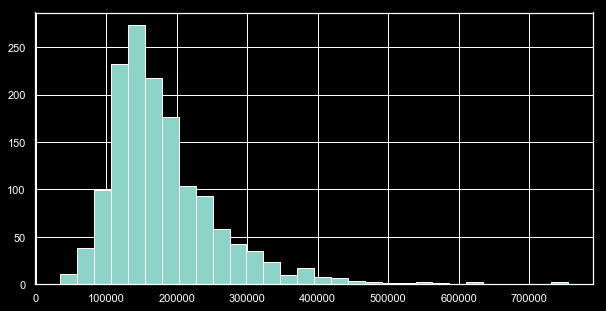

In [41]:
fig, ax = plt.subplots(nrows= 1,ncols = 1, figsize=(10,5))
ax.hist(df_train['SalePrice'], bins=30)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'BsmtFinSF2')

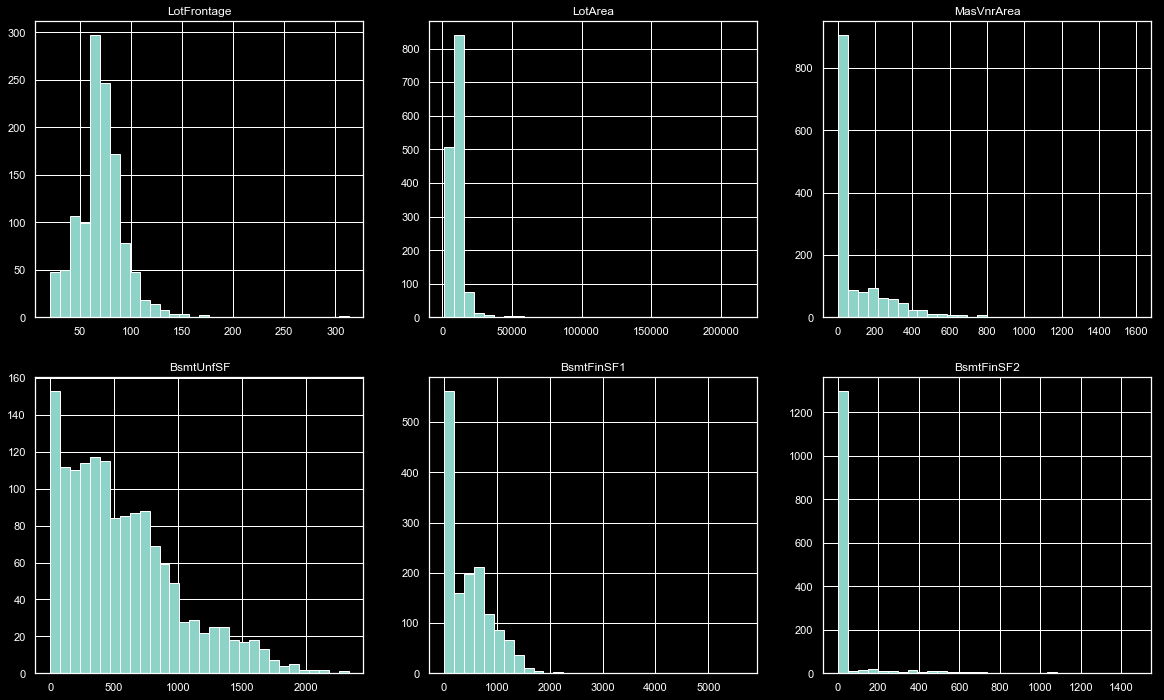

In [42]:
fig, axes = plt.subplots(nrows= 2,ncols = 3, figsize=(20,12))
axes[0,0].hist(df_train['LotFrontage'], bins=30)
axes[0,0].set_title('LotFrontage', fontsize=12)
axes[0,1].hist(df_train['LotArea'], bins=30)
axes[0,1].set_title('LotArea', fontsize=12)
axes[0,2].hist(df_train['MasVnrArea'], bins=30)
axes[0,2].set_title('MasVnrArea', fontsize=12)
axes[1,0].hist(df_train['BsmtUnfSF'], bins=30)
axes[1,0].set_title('BsmtUnfSF', fontsize=12)
axes[1,1].hist(df_train['BsmtFinSF1'], bins=30)
axes[1,1].set_title('BsmtFinSF1', fontsize=12)
axes[1,2].hist(df_train['BsmtFinSF2'], bins=30)
axes[1,2].set_title('BsmtFinSF2', fontsize=12)

Text(0.5, 1.0, 'GarageArea')

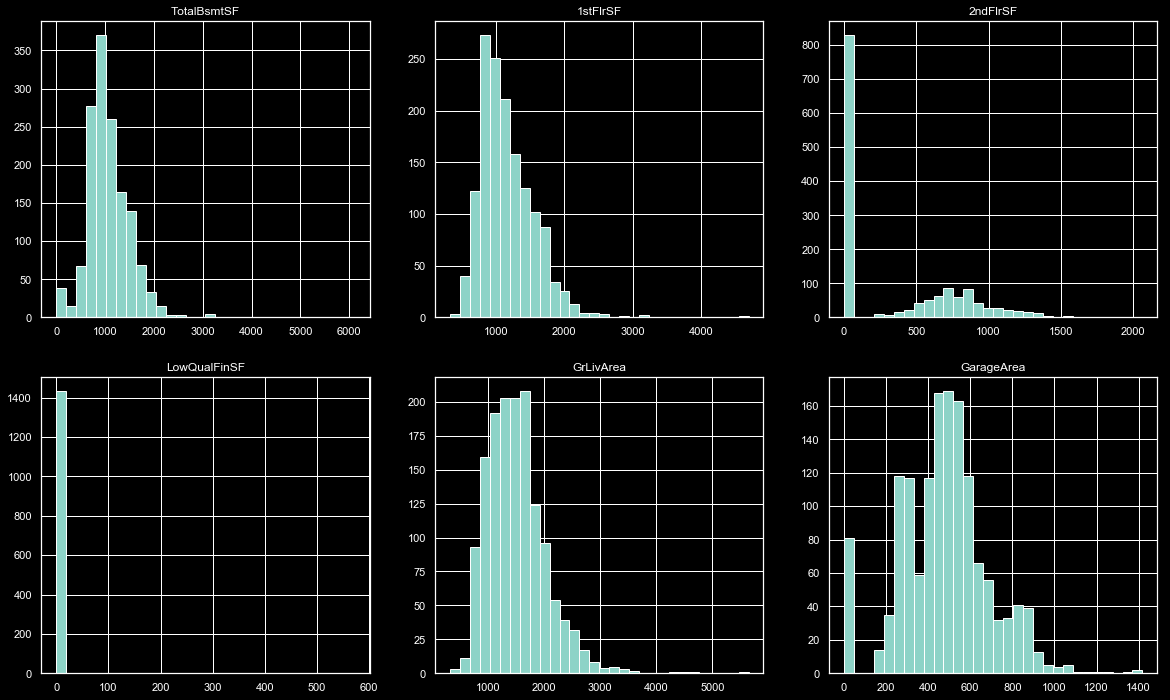

In [43]:
fig, axes = plt.subplots(nrows= 2,ncols = 3, figsize=(20,12))
axes[0,0].hist(df_train['TotalBsmtSF'], bins=30)
axes[0,0].set_title('TotalBsmtSF', fontsize=12)
axes[0,1].hist(df_train['1stFlrSF'], bins=30)
axes[0,1].set_title('1stFlrSF', fontsize=12)
axes[0,2].hist(df_train['2ndFlrSF'], bins=30)
axes[0,2].set_title('2ndFlrSF', fontsize=12)
axes[1,0].hist(df_train['LowQualFinSF'], bins=30)
axes[1,0].set_title('LowQualFinSF', fontsize=12)
axes[1,1].hist(df_train['GrLivArea'], bins=30)
axes[1,1].set_title('GrLivArea', fontsize=12)
axes[1,2].hist(df_train['GarageArea'], bins=30)
axes[1,2].set_title('GarageArea', fontsize=12)

# 1.10 Looking for chances to aggregate categorical variables

In [44]:
df_train.groupby('Neighborhood') \
    .agg({'Neighborhood':'size', 'SalePrice':'mean'}) \
    .sort_values(by='SalePrice') \
    .rename(columns={'Neighborhood':'count','SalePrice':'mean'}) 

,count,mean
Neighborhood,,
MeadowV,17,98576.470588
IDOTRR,37,100123.783784
BrDale,16,104493.750000
BrkSide,58,124834.051724
Edwards,100,128219.700000
OldTown,113,128225.300885
Sawyer,74,136793.135135
Blueste,2,137500.000000
SWISU,25,142591.360000


# 2. Cleaning the dataset

## 2.1 Drop the ID and correlated columns from train and test datasets

In [45]:
test_ids = df_test['Id']
df_train.drop(columns=['Id', 'GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars'], axis=1, inplace=True)
df_test.drop(columns=['Id', 'GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars'], axis=1, inplace=True)

## 2.2 Drop outliers

This is the function to drop outliers for a single column

In [46]:
def dropColOutliers(df, col, factor):
    mean = df[col].mean()
    std = df[col].std()
    df.drop(df[df[col] > (mean + factor * std)].index, inplace=True)
    df.drop(df[df[col] < (mean - factor * std)].index, inplace=True)
    return df

Don't drop outliers in the train dataset for now

## 2.3 Fill NAs

In [47]:
# Save mode values from train dataset
all_mode = df_train.mode()

def fillNAs(df, all_mode):
    df['PoolQC'].fillna('NA', inplace=True)
    df['MiscFeature'].fillna('NA', inplace=True)
    df['Alley'].fillna('NA', inplace=True)
    df['Fence'].fillna('NA', inplace=True)
    df['FireplaceQu'].fillna('NA', inplace=True)
    # I assume that when LotFrontage is NA, there is no street connections with property
    df['LotFrontage'].fillna(0, inplace=True)
    # Absence of garage
    df['GarageType'].fillna('NA', inplace=True)
    NA_indx = df[(df.GarageType.isnull() == False) & df.GarageFinish.isnull()].index
    df['GarageFinish'].loc[NA_indx] = all_mode['GarageFinish'][0]
    df['GarageFinish'].fillna('NA', inplace=True)
    NA_indx = df[(df.GarageType.isnull() == False) & df.GarageQual.isnull()].index
    df['GarageQual'].loc[NA_indx] = all_mode['GarageQual'][0]
    df['GarageQual'].fillna('NA', inplace=True)
    NA_indx = df[(df.GarageType.isnull() == False) & df.GarageCond.isnull()].index
    df['GarageCond'].loc[NA_indx] = all_mode['GarageCond'][0]
    df['GarageCond'].fillna('NA', inplace=True)
    NA_indx = df[(df.GarageType.isnull() == False) & df.GarageArea.isnull()].index
    df['GarageArea'].loc[NA_indx] = all_mode['GarageArea'][0]
    df['GarageArea'].fillna(0, inplace=True)    
    # Absence of basement
    df['BsmtFinType1'].fillna('NA', inplace=True)
    df['BsmtExposure'].fillna('NA', inplace=True)
    df['BsmtCond'].fillna('NA', inplace=True)
    df['BsmtQual'].fillna('NA', inplace=True)
    df['BsmtFinType2'].fillna('NA', inplace=True)
    df['TotalBsmtSF'].fillna(0, inplace=True)
    # No masonry veneer
    df['MasVnrType'].fillna('None', inplace=True)
    df['MasVnrArea'].fillna(0, inplace=True)
    # When Electrical is not defined, better use Mix value
    df['Electrical'].fillna('Mix', inplace=True)    
    df['MSZoning'].fillna('NA', inplace=True)
    df['Functional'].fillna('Typ', inplace=True)
    df['BsmtHalfBath'].fillna(0, inplace=True)
    df['BsmtFullBath'].fillna(0, inplace=True)
    df['Utilities'].fillna('AllPub', inplace=True)
    df['SaleType'].fillna('Oth', inplace=True)
    df['KitchenQual'].fillna(all_mode['KitchenQual'][0], inplace=True)
    df['BsmtUnfSF'].fillna(0, inplace=True)
    df['BsmtFinSF1'].fillna(0, inplace=True)
    df['BsmtFinSF2'].fillna(0, inplace=True)
    df['Exterior1st'].fillna(all_mode['Exterior1st'][0], inplace=True)
    df['Exterior2nd'].fillna(all_mode['Exterior2nd'][0], inplace=True)

In [48]:
fillNAs(df_train, all_mode)
fillNAs(df_test, all_mode)
print(df_train.isnull().any().any())
print(df_test.isnull().any().any())

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


False
False


## 2.4 Separate the target feature from the training dataset

In [49]:
target = df_train['SalePrice']
df_train.drop('SalePrice', axis=1, inplace=True)

# 3. Feature Engineering

## 3.1 Aggregations

In [50]:
def aggregation(df):
    df['Neighborhood'] = df['Neighborhood'].map(
        {'MeadowV': 0,
        'IDOTRR': 0,
        'BrDale': 0,
        'BrkSide': 0,
        'Edwards': 0,
        'OldTown': 0,
        'Sawyer': 0,
        'Blueste': 0,
        'SWISU': 0,
        'NPkVill': 0,
        'NAmes': 0,
        'Mitchel': 0,
        'SawyerW': 0,
        'NWAmes': 0,
        'Gilbert': 0,
        'Blmngtn': 0,
        'CollgCr': 0,
        'Crawfor': 1,
        'ClearCr': 1,
        'Somerst': 1,
        'Veenker': 1,
        'Timber': 1,
        'StoneBr': 2,
        'NridgHt': 2,
        'NoRidge': 2})
    
    df['MSZoning'] = df['MSZoning'].map(
        {'A': 0,
         'C': 0,
         'FV': 1,
         'I': 0,
         'RH': 1,
         'RL': 1,
         'RP': 1,
         'RM': 1})
    
    df['TotFullBath'] = df['BsmtFullBath'] + df['FullBath']
    df['TotHalfBath'] = df['BsmtHalfBath'] + df['HalfBath']
    
    df['HouseStyle_stories'] = df['HouseStyle'].map(
        {'1Story': 1,
         '1.5Fin': 1.5,
         '1.5Unf': 1.5,
         '2Story': 2,
         '2.5Fin': 2.5,
         '2.5Unf': 2.5,
         'SFoyer': 1.5,
         'SLvl': 1.5})

    df['HouseStyle_fin'] = df['HouseStyle'].map(
        {'1Story': 1,
         '1.5Fin': 1,
         '1.5Unf': 0,
         '2Story': 1,
         '2.5Fin': 1,
         '2.5Unf': 0,
         'SFoyer': 1,
         'SLvl': 1})

In [51]:
aggregation(df_train)
aggregation(df_test)

## 3.2 One-hot-encoding

Change all categorical columns in binaries with one-hot-encoding for train and test dataset

In [52]:
col_types = df_train.dtypes
df_train = pd.get_dummies(df_train, columns=col_types[col_types == 'object'].index.values, drop_first=True)
df_test = pd.get_dummies(df_test, columns=col_types[col_types == 'object'].index.values, drop_first=True)
print(df_train.shape)
print(df_test.shape)

(1460, 230)
(1459, 212)


Add missing column in test dataset and drop those that don't exists in trainig dataset. The difference could be caused by the one-hot-encoding

In [53]:
def adapt_columns(train_columns, df):
    # Add missing columns
    for column in train_columns:
        if (column not in df.columns):
            df[column] = 0

    # Delete columns that don't exist in train
    for column in df.columns:
        if (column not in train_columns):
            df.drop(column, axis=1, inplace=True)
    return df

In [54]:
adapt_columns(df_train.columns, df_test)
print(df_train.shape)
print(df_test.shape)

(1460, 230)
(1459, 230)


## 3.3 Normalization

Rescale all features in numbers between 0 and 1

In [55]:
def normalization(df):
    array_val = df.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    array_norm = min_max_scaler.fit_transform(array_val)
    return pd.DataFrame(data=array_norm, columns=df.columns.values)

In [56]:
df_train = normalization(df_train)
df_test = normalization(df_test)

# 4. Hyperparameters optimization

In [57]:
#params = {'min_child_weight': [10, 15, 20],
#          'reg_lambda': [1, 5, 10],
#          'gamma': [0.5, 0.8],
#          'max_depth': [8, 15, 20],
#          'learning_rate':[0.2],
#          'n_estimators': [20, 30, 40]}
params = {
 'max_depth': [4], #[5, 10, 15, 20, 25],
 'min_child_weight': [9],  #[5, 10, 15, 20, 25],
 'gamma': [0.0],  #[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
 'subsample': [1.0], #[0.7, 0.8, 0.9, 1.0],
 'colsample_bytree': [1.0], #[0.7, 0.8, 0.9, 1.0]
 'reg_alpha': [0.0, 0.02, 0.1, 0.5, 2, 10]
}

#model = xgb.XGBRegressor(objective='reg:linear', verbosity=0)

#xgb_tune = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=2, n_jobs=4)
#xgb_tune.fit(df_train.values, target.values)

#print(xgb_tune.best_params_)

Difinitive hyperparameters:

In [58]:
xgb_params = {'max_depth': 4, 
              'min_child_weight': 9,
              'gamma': 0.0,
              'colsample_bytree': 1.0,
              'subsample': 1.0,
              'reg_alpha': 0.005,
              'learning_rate': 0.01,
              'n_estimators': 5000}

# 5. Train the model with XGBoost Regressor

In [59]:
mae = 0
rmsle = 0
splits = 10

kf = KFold(n_splits=splits, shuffle=True, random_state=12345)

for train_index, test_index in kf.split(df_train):
    X_train_k, X_test_k = df_train.values[train_index], df_train.values[test_index]
    y_train_k, y_test_k = target.values[train_index], target.values[test_index]      
    
    model_k = xgb.XGBRegressor(params=xgb_params)    
    model_k.fit(X_train_k, y_train_k)
    y_pred_k = model_k.predict(X_test_k)
    
    np.round(y_pred_k)
    mae = mae + median_absolute_error(y_test_k, y_pred_k)
    #y_pred_k[y_pred_k < 0] = 0
    rmsle = rmsle + np.sqrt(mean_squared_log_error(y_test_k, y_pred_k))

print('MAE: ' + '{:.2f}'.format(mae/splits)) 
print('RMSLE: ' + '{:.4f}'.format(rmsle/splits)) 

MAE: 9951.69
RMSLE: 0.1284


# 6. Train the final model and make predictions on the test dataset

In [60]:
model = xgb.XGBRegressor(params=xgb_params)
model.fit(df_train.values, target.values)
y_pred = model.predict(df_test.values)

df_pred = pd.DataFrame(data=y_pred, columns=['SalePrice'])
df_pred = pd.concat([test_ids, df_pred['SalePrice']], axis=1)
df_pred.SalePrice = df_pred.SalePrice.round(0)
df_pred.to_csv('submission.csv', sep=',', encoding='utf-8', index=False)